# CelebA - Generative Adversarial Network


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten  
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf

In [ ]:
# ls

In [4]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/PlakshaLabs/ganproject/orl/img_align_celeba' 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# cd drive/MyDrive/Plakshadata

In [6]:
# ls

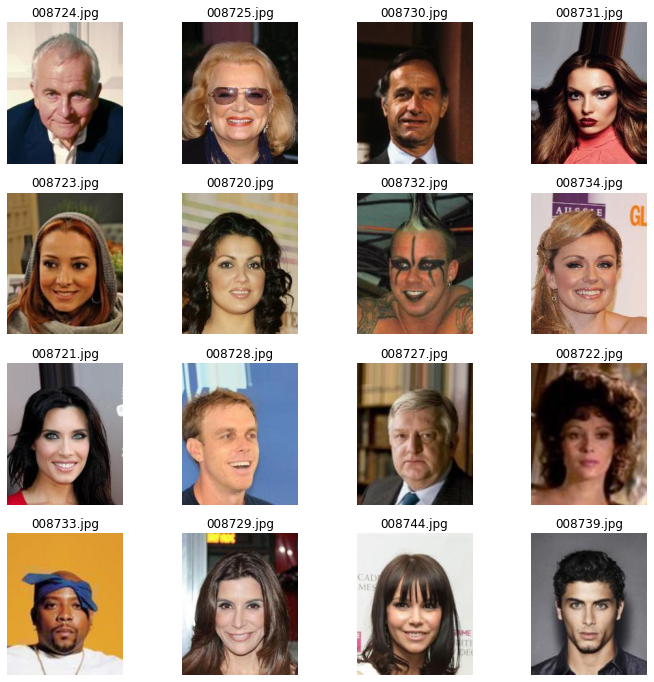

In [13]:
n_images = 12000
batch_size = 128
latent_dim = 100
img_shape = (128, 128, 3)
images = os.listdir(data_dir)
images = images[:n_images]
n_epoch = 120

def get_data(data_path) :
    X = []
    for filename in data_path :
        img = img_to_array(load_img(data_dir + "/" + filename, target_size = img_shape[:2]))
        X.append(img)
    X = np.array(X).astype('float32')
    X = X / 255
    return X

dataset = get_data(images)
plt.figure(figsize=(12,12))
for i, name in enumerate(images[0:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(data_dir + '/' + name)
    plt.imshow(img)
    plt.title(name)
    plt.axis('off')

#Generator & Discriminator

In [14]:
def generatorfn(latent_dim):
    model = Sequential()
    n_nodes = 128 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model


def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return x, y


def discriminatorfn(in_shape=(128,128,3)):
    model = Sequential()
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# GAN

In [16]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y


def show_generated(generated,epoch, n=5):
    plt.figure(figsize=(10,10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated[i])
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()
    
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy [real: %.0f%%, fake: %.0f%%]' % (acc_real*100, acc_fake*100))
    show_generated(x_fake, epoch)    

def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    start = time.time()
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (i+1, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)     
    print ('Total time for training {} epochs is {} sec'.format(n_epochs, (time.time()-start)))

Epoch: 1,  Loss: D_real = 0.131, D_fake = 0.669,  G = 0.848
Epoch: 2,  Loss: D_real = 0.214, D_fake = 0.516,  G = 1.823
Epoch: 3,  Loss: D_real = 0.519, D_fake = 0.574,  G = 1.022
Epoch: 4,  Loss: D_real = 0.506, D_fake = 0.416,  G = 1.470
Epoch: 5,  Loss: D_real = 0.599, D_fake = 0.590,  G = 1.057
Epoch: 6,  Loss: D_real = 0.639, D_fake = 0.384,  G = 1.694
Epoch: 7,  Loss: D_real = 0.619, D_fake = 0.666,  G = 0.767
Epoch: 8,  Loss: D_real = 0.636, D_fake = 0.609,  G = 0.944
Epoch: 9,  Loss: D_real = 0.578, D_fake = 0.613,  G = 0.984
Epoch: 10,  Loss: D_real = 0.548, D_fake = 0.577,  G = 1.176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 60%, fake: 88%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

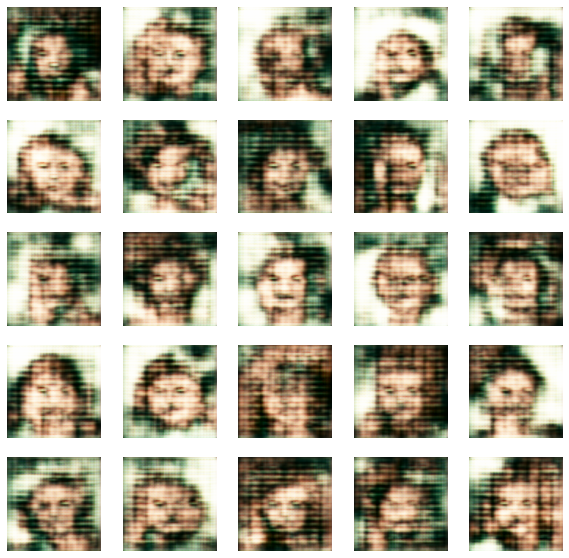

Epoch: 11,  Loss: D_real = 0.422, D_fake = 0.715,  G = 1.713
Epoch: 12,  Loss: D_real = 0.578, D_fake = 0.623,  G = 1.118
Epoch: 13,  Loss: D_real = 0.830, D_fake = 0.526,  G = 1.301
Epoch: 14,  Loss: D_real = 0.399, D_fake = 0.560,  G = 1.233
Epoch: 15,  Loss: D_real = 0.474, D_fake = 0.519,  G = 1.307
Epoch: 16,  Loss: D_real = 0.644, D_fake = 0.513,  G = 1.137
Epoch: 17,  Loss: D_real = 0.516, D_fake = 0.407,  G = 1.721
Epoch: 18,  Loss: D_real = 0.418, D_fake = 0.889,  G = 2.395
Epoch: 19,  Loss: D_real = 0.599, D_fake = 0.554,  G = 1.695
Epoch: 20,  Loss: D_real = 0.691, D_fake = 0.458,  G = 1.669


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 55%, fake: 85%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

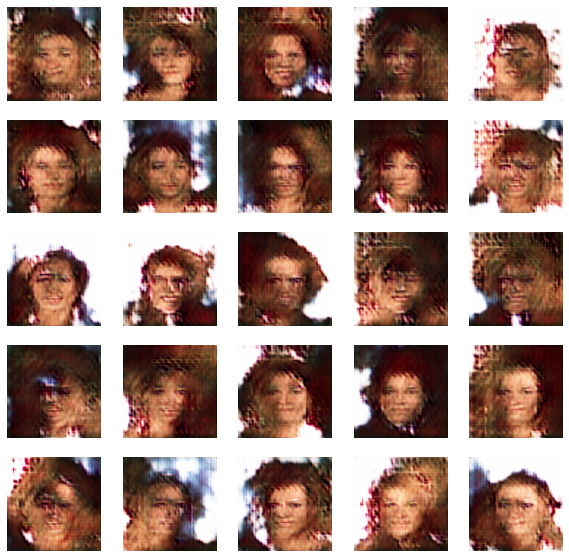

Epoch: 21,  Loss: D_real = 2.245, D_fake = 0.659,  G = 1.937
Epoch: 22,  Loss: D_real = 0.405, D_fake = 0.274,  G = 1.874
Epoch: 23,  Loss: D_real = 0.716, D_fake = 0.471,  G = 1.650
Epoch: 24,  Loss: D_real = 0.541, D_fake = 0.462,  G = 2.001
Epoch: 25,  Loss: D_real = 0.558, D_fake = 0.408,  G = 2.007
Epoch: 26,  Loss: D_real = 0.285, D_fake = 0.417,  G = 1.989
Epoch: 27,  Loss: D_real = 0.423, D_fake = 0.301,  G = 2.333
Epoch: 28,  Loss: D_real = 0.498, D_fake = 0.424,  G = 2.080
Epoch: 29,  Loss: D_real = 0.351, D_fake = 0.466,  G = 2.238
Epoch: 30,  Loss: D_real = 0.505, D_fake = 0.501,  G = 2.540


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 89%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

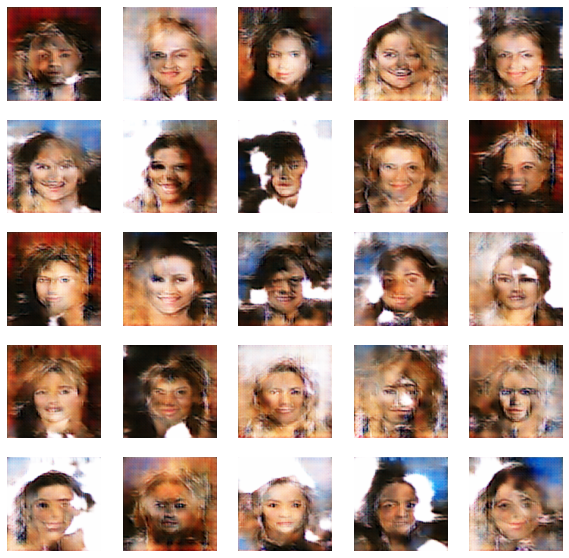

Epoch: 31,  Loss: D_real = 0.396, D_fake = 0.469,  G = 2.462
Epoch: 32,  Loss: D_real = 0.403, D_fake = 0.485,  G = 2.645
Epoch: 33,  Loss: D_real = 0.320, D_fake = 0.357,  G = 2.643
Epoch: 34,  Loss: D_real = 0.440, D_fake = 0.290,  G = 2.803
Epoch: 35,  Loss: D_real = 0.333, D_fake = 0.393,  G = 2.237
Epoch: 36,  Loss: D_real = 0.307, D_fake = 0.285,  G = 3.033
Epoch: 37,  Loss: D_real = 0.404, D_fake = 0.365,  G = 2.881
Epoch: 38,  Loss: D_real = 0.421, D_fake = 0.499,  G = 3.081
Epoch: 39,  Loss: D_real = 0.310, D_fake = 0.189,  G = 3.269
Epoch: 40,  Loss: D_real = 0.377, D_fake = 0.121,  G = 2.759


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 86%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

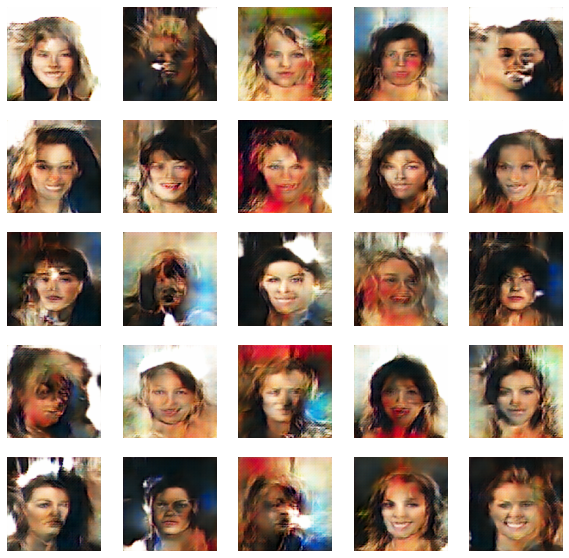

Epoch: 41,  Loss: D_real = 0.394, D_fake = 0.299,  G = 2.902
Epoch: 42,  Loss: D_real = 0.352, D_fake = 0.448,  G = 3.153
Epoch: 43,  Loss: D_real = 0.428, D_fake = 0.336,  G = 2.092
Epoch: 44,  Loss: D_real = 0.289, D_fake = 0.364,  G = 3.318
Epoch: 45,  Loss: D_real = 0.434, D_fake = 0.353,  G = 3.148
Epoch: 46,  Loss: D_real = 0.206, D_fake = 0.296,  G = 3.040
Epoch: 47,  Loss: D_real = 0.388, D_fake = 0.328,  G = 2.905
Epoch: 48,  Loss: D_real = 0.353, D_fake = 0.354,  G = 2.798
Epoch: 49,  Loss: D_real = 0.163, D_fake = 0.024,  G = 5.748
Epoch: 50,  Loss: D_real = 0.130, D_fake = 0.206,  G = 3.358


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 92%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

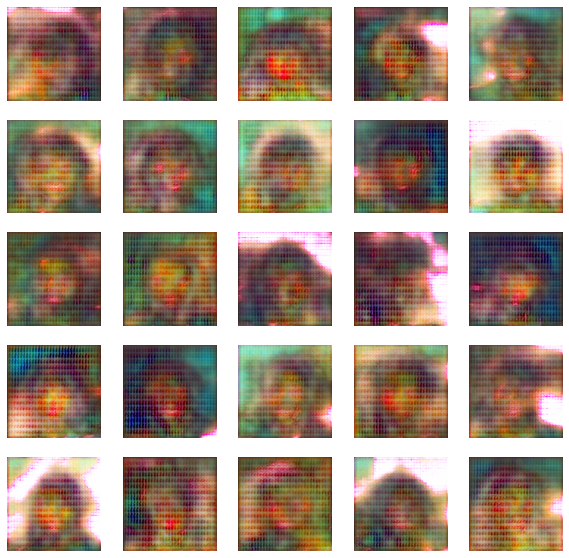

Epoch: 51,  Loss: D_real = 0.108, D_fake = 0.082,  G = 4.157
Epoch: 52,  Loss: D_real = 0.264, D_fake = 0.345,  G = 3.361
Epoch: 53,  Loss: D_real = 0.174, D_fake = 0.244,  G = 3.781
Epoch: 54,  Loss: D_real = 0.395, D_fake = 0.320,  G = 2.689
Epoch: 55,  Loss: D_real = 0.212, D_fake = 0.114,  G = 3.654
Epoch: 56,  Loss: D_real = 0.275, D_fake = 0.130,  G = 3.161
Epoch: 57,  Loss: D_real = 0.293, D_fake = 0.275,  G = 3.929
Epoch: 58,  Loss: D_real = 0.233, D_fake = 0.141,  G = 3.165
Epoch: 59,  Loss: D_real = 0.179, D_fake = 0.205,  G = 3.864
Epoch: 60,  Loss: D_real = 0.325, D_fake = 0.314,  G = 2.943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 90%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

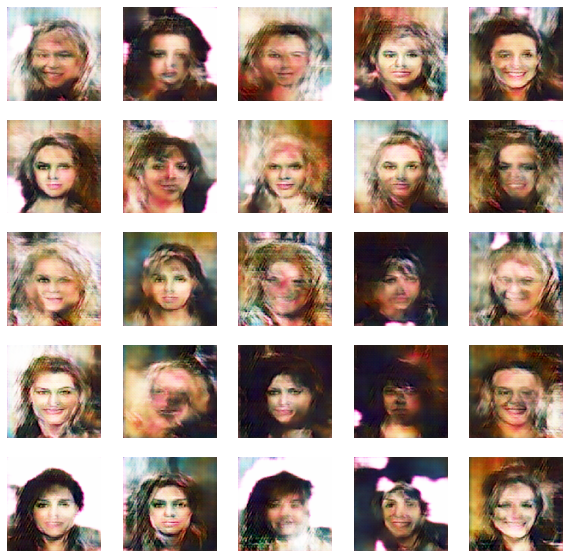

Epoch: 61,  Loss: D_real = 0.164, D_fake = 0.333,  G = 3.998
Epoch: 62,  Loss: D_real = 0.252, D_fake = 0.294,  G = 3.346
Epoch: 63,  Loss: D_real = 0.223, D_fake = 0.223,  G = 2.892
Epoch: 64,  Loss: D_real = 0.228, D_fake = 0.229,  G = 3.343
Epoch: 65,  Loss: D_real = 0.185, D_fake = 0.266,  G = 2.998
Epoch: 66,  Loss: D_real = 0.098, D_fake = 0.202,  G = 3.481
Epoch: 67,  Loss: D_real = 0.378, D_fake = 0.231,  G = 2.846
Epoch: 68,  Loss: D_real = 0.223, D_fake = 0.169,  G = 3.281
Epoch: 69,  Loss: D_real = 0.154, D_fake = 0.135,  G = 3.310
Epoch: 70,  Loss: D_real = 0.217, D_fake = 0.137,  G = 3.489


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 86%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

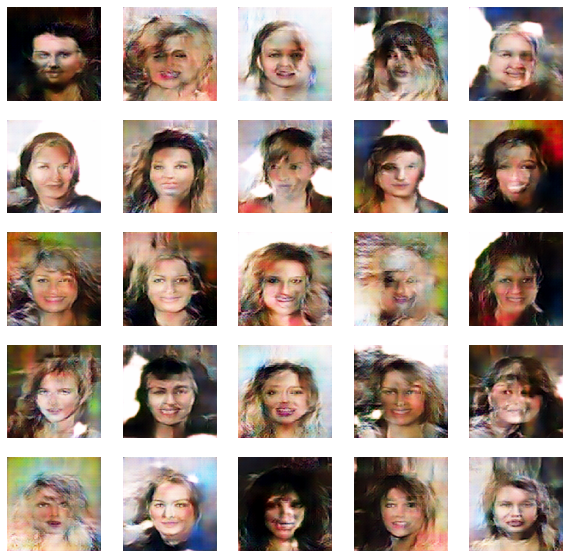

Epoch: 71,  Loss: D_real = 0.179, D_fake = 0.191,  G = 3.036
Epoch: 72,  Loss: D_real = 0.230, D_fake = 0.236,  G = 3.083
Epoch: 73,  Loss: D_real = 0.208, D_fake = 0.216,  G = 3.599
Epoch: 74,  Loss: D_real = 0.172, D_fake = 0.119,  G = 3.787
Epoch: 75,  Loss: D_real = 0.151, D_fake = 0.117,  G = 3.997
Epoch: 76,  Loss: D_real = 0.660, D_fake = 0.597,  G = 3.566
Epoch: 77,  Loss: D_real = 0.127, D_fake = 0.176,  G = 4.129
Epoch: 78,  Loss: D_real = 0.148, D_fake = 0.125,  G = 3.944
Epoch: 79,  Loss: D_real = 0.298, D_fake = 0.200,  G = 3.178
Epoch: 80,  Loss: D_real = 0.170, D_fake = 0.075,  G = 3.927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 93%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

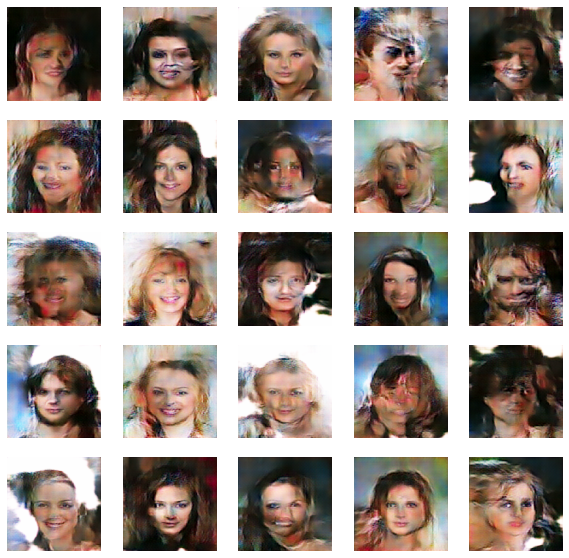

Epoch: 81,  Loss: D_real = 0.354, D_fake = 0.515,  G = 4.465
Epoch: 82,  Loss: D_real = 0.076, D_fake = 0.056,  G = 3.982
Epoch: 83,  Loss: D_real = 0.173, D_fake = 0.117,  G = 3.817
Epoch: 84,  Loss: D_real = 0.115, D_fake = 0.120,  G = 3.722
Epoch: 85,  Loss: D_real = 0.122, D_fake = 0.110,  G = 3.990
Epoch: 86,  Loss: D_real = 0.218, D_fake = 0.194,  G = 4.186
Epoch: 87,  Loss: D_real = 0.826, D_fake = 0.739,  G = 1.205
Epoch: 88,  Loss: D_real = 0.286, D_fake = 0.264,  G = 3.403
Epoch: 89,  Loss: D_real = 0.328, D_fake = 0.227,  G = 2.378
Epoch: 90,  Loss: D_real = 0.460, D_fake = 0.171,  G = 2.470


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Accuracy [real: 88%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

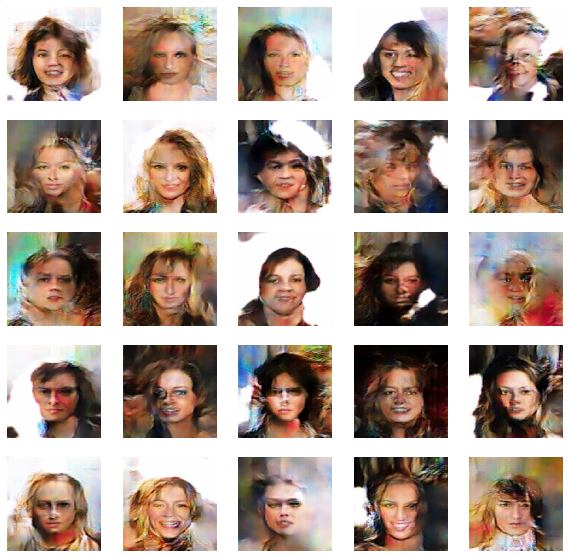

Epoch: 91,  Loss: D_real = 0.167, D_fake = 0.107,  G = 3.827
Epoch: 92,  Loss: D_real = 0.316, D_fake = 0.335,  G = 3.042
Epoch: 93,  Loss: D_real = 0.274, D_fake = 0.226,  G = 3.151
Epoch: 94,  Loss: D_real = 0.218, D_fake = 0.102,  G = 3.302
Epoch: 95,  Loss: D_real = 0.286, D_fake = 0.197,  G = 3.129
Epoch: 96,  Loss: D_real = 0.211, D_fake = 0.196,  G = 3.757
Epoch: 97,  Loss: D_real = 0.247, D_fake = 0.113,  G = 3.375
Epoch: 98,  Loss: D_real = 0.220, D_fake = 0.130,  G = 4.553
Epoch: 99,  Loss: D_real = 0.114, D_fake = 0.062,  G = 3.744
Epoch: 100,  Loss: D_real = 0.234, D_fake = 1.074,  G = 4.217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 26%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

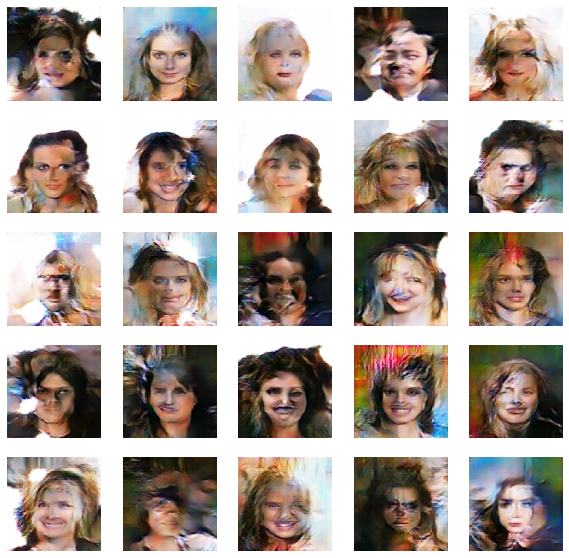

Epoch: 101,  Loss: D_real = 0.349, D_fake = 0.102,  G = 3.369
Epoch: 102,  Loss: D_real = 0.120, D_fake = 0.108,  G = 4.403
Epoch: 103,  Loss: D_real = 0.247, D_fake = 0.100,  G = 4.136
Epoch: 104,  Loss: D_real = 0.435, D_fake = 0.364,  G = 2.858
Epoch: 105,  Loss: D_real = 0.300, D_fake = 0.133,  G = 4.596
Epoch: 106,  Loss: D_real = 0.272, D_fake = 0.289,  G = 4.137
Epoch: 107,  Loss: D_real = 0.591, D_fake = 0.460,  G = 2.391
Epoch: 108,  Loss: D_real = 0.307, D_fake = 0.268,  G = 3.760
Epoch: 109,  Loss: D_real = 0.201, D_fake = 0.131,  G = 3.560
Epoch: 110,  Loss: D_real = 0.335, D_fake = 0.278,  G = 3.372


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 95%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

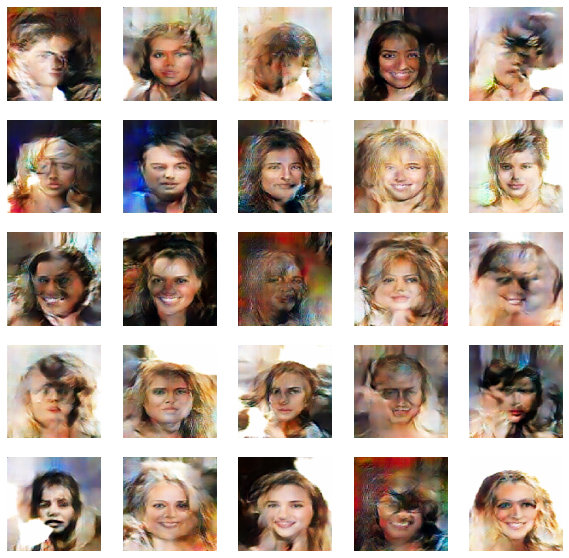

Epoch: 111,  Loss: D_real = 0.248, D_fake = 0.166,  G = 4.071
Epoch: 112,  Loss: D_real = 0.104, D_fake = 0.131,  G = 4.353
Epoch: 113,  Loss: D_real = 0.396, D_fake = 0.102,  G = 3.283
Epoch: 114,  Loss: D_real = 0.251, D_fake = 0.081,  G = 4.070
Epoch: 115,  Loss: D_real = 0.261, D_fake = 0.331,  G = 4.762
Epoch: 116,  Loss: D_real = 0.087, D_fake = 0.154,  G = 5.144
Epoch: 117,  Loss: D_real = 0.170, D_fake = 0.102,  G = 4.585
Epoch: 118,  Loss: D_real = 0.127, D_fake = 0.107,  G = 4.101
Epoch: 119,  Loss: D_real = 0.243, D_fake = 0.134,  G = 4.352
Epoch: 120,  Loss: D_real = 0.296, D_fake = 0.133,  G = 3.295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

>Accuracy [real: 95%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

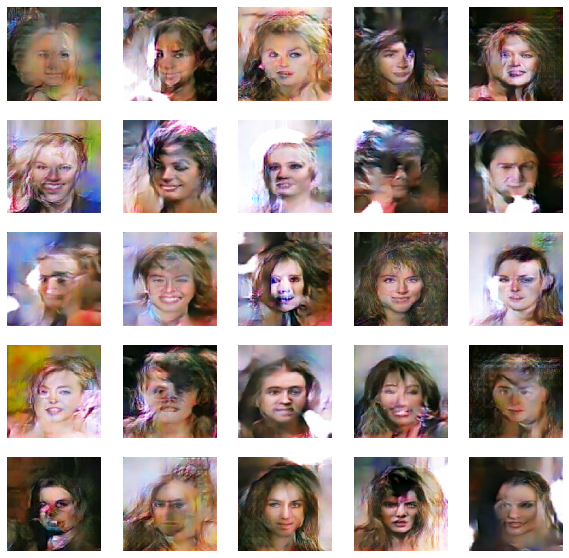

Total time for training 120 epochs is 7701.2726311683655 sec


In [18]:
discriminator = discriminatorfn()
generator = generatorfn(latent_dim)
gan = define_gan(generator, discriminator)
train(generator, discriminator, gan, dataset, latent_dim, n_epoch, batch_size)